# CMIP6 Precipitation Frequency Analysis

This notebook shows an advanced analysis case. The calculation was inspired by Angie Pendergrass’s work on precipitation statistics, as described in the following websites / papers:

- https://journals.ametsoc.org/doi/full/10.1175/JCLI-D-16-0684.1
- https://climatedataguide.ucar.edu/climate-data/gpcp-daily-global-precipitation-climatology-project

We use [xhistogram](https://xhistogram.readthedocs.io/) to calculate the distribution of precipitation intensity and its changes in a warming climate.

In [1]:
import os

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import fsspec
from tqdm.autonotebook import tqdm

from xhistogram.xarray import histogram

%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 6
%config InlineBackend.figure_format = 'retina' 

/tmp/ipykernel_425/1236161017.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


### Compute Cluster

Here we use a dask cluster to parallelize our analysis. The cluster scales up and down adaptively.

In [ ]:
import dask
from dask.distributed import Client, LocalCluster
from dask_cloudprovider.aws import FargateCluster

# Start a local Dask cluster
# IF YOU WILL RUN THIS PIPELINE WITH LOCALHOST, YOU WILL NEED A BIG MACHINE!!!
# cluster = LocalCluster(n_workers=1)

# Start a Fargate Dask cluster
cluster = FargateCluster(
    n_workers=20,
    region_name="us-east-1",
)

client = Client(cluster)
client

/opt/conda/lib/python3.12/contextlib.py:144: UserWarning: Creating your cluster is taking a surprisingly long time. This is likely due to pending resources on AWS. Hang tight! 
  next(self.gen)


<Client: 'tcp://172.31.30.203:8786' processes=19 threads=76, memory=283.12 GiB>

### Load Data Catalog

In [3]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,ps,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
1,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rsds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
2,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlus,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
3,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
4,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,psl,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706


In [4]:
df_3hr_pr = df[(df.table_id == '3hr') & (df.variable_id == 'pr')]
len(df_3hr_pr)

78

In [5]:
run_counts = df_3hr_pr.groupby(['source_id', 'experiment_id'])['zstore'].count()
run_counts

source_id         experiment_id     
BCC-CSM2-MR       historical             1
                  ssp126                 1
                  ssp245                 1
                  ssp370                 1
                  ssp585                 1
CNRM-CM6-1        highresSST-present     1
                  historical             3
                  ssp126                 1
                  ssp245                 1
                  ssp370                 1
                  ssp585                 1
CNRM-CM6-1-HR     highresSST-present     1
CNRM-ESM2-1       historical             1
                  ssp126                 1
                  ssp245                 1
                  ssp370                 1
                  ssp585                 1
GFDL-CM4          1pctCO2                2
                  abrupt-4xCO2           2
                  amip                   2
                  historical             2
                  piControl              2
GFDL-CM4C192     

In [6]:
source_ids = []
experiment_ids = ['historical', 'ssp585']
for name, group in df_3hr_pr.groupby('source_id'):
    if all([expt in group.experiment_id.values
            for expt in experiment_ids]):
        source_ids.append(name)
source_ids

['BCC-CSM2-MR', 'CNRM-CM6-1', 'CNRM-ESM2-1', 'IPSL-CM6A-LR']

In [7]:
def load_pr_data(source_id, expt_id):
    """
    Load 3hr precip data for given source and expt ids
    """
    uri = df_3hr_pr[(df_3hr_pr.source_id == source_id) &
                     (df_3hr_pr.experiment_id == expt_id)].zstore.values[0]
    
    # Try different approaches to open the zarr store
    try:
        # Try the simple approach first
        ds = xr.open_zarr(uri, consolidated=True, mask_and_scale=True)
    except TypeError:
        # If that fails, try using a zarr.DirectoryStore
        import zarr
        mapper = fsspec.get_mapper(uri)
        # Use zarr's DirectoryStore which is compatible with FSMap
        store = zarr.storage.DirectoryStore(mapper.root, fs=mapper.fs)
        ds = xr.open_zarr(store, consolidated=True, mask_and_scale=True)
    return ds

In [8]:
def precip_hist(ds, nbins=100, pr_log_min=-3, pr_log_max=2):
    """
    Calculate precipitation histogram for a single model. 
    Lazy.
    """
    assert ds.pr.units == 'kg m-2 s-1'
    
    # mm/day
    bins_mm_day = np.hstack([[0], np.logspace(pr_log_min, pr_log_max, nbins)]) 
    bins_kg_m2s = bins_mm_day / (24*60*60)

    pr_hist = histogram(ds.pr, bins=[bins_kg_m2s], dim=['lon']).mean(dim='time')
    
    log_bin_spacing = np.diff(np.log(bins_kg_m2s[1:3])).item()
    pr_hist_norm = 100 * pr_hist / ds.dims['lon'] / log_bin_spacing
    pr_hist_norm.attrs.update({'long_name': 'zonal mean rain frequency',
                               'units': '%/Δln(r)'})
    return pr_hist_norm

def precip_hist_for_expts(dsets, experiment_ids):
    """
    Calculate histogram for a suite of experiments.
    Eager.
    """
    # actual data loading and computations happen in this next line
    pr_hists = [precip_hist(ds).load() for ds in dsets]
    pr_hist = xr.concat(pr_hists, dim=xr.Variable('experiment_id', experiment_ids))
    return pr_hist

In [9]:
results = {}
for source_id in tqdm(source_ids):
    # get a 20 year period
    ds_hist = load_pr_data(source_id, 'historical').sel(time=slice('1980', '2000'))
    ds_ssp = load_pr_data(source_id, 'ssp585').sel(time=slice('2080', '2100'))
    pr_hist = precip_hist_for_expts([ds_hist, ds_ssp], experiment_ids)
    results[source_id] = pr_hist

  0%|          | 0/4 [00:00<?, ?it/s]

/tmp/ipykernel_425/2519268891.py:15: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  pr_hist_norm = 100 * pr_hist / ds.dims['lon'] / log_bin_spacing
/tmp/ipykernel_425/2519268891.py:15: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  pr_hist_norm = 100 * pr_hist / ds.dims['lon'] / log_bin_spacing
/tmp/ipykernel_425/2519268891.py:15: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  pr_hist_norm = 10

In [10]:
def plot_precip_changes(pr_hist, vmax=5):
    """
    Visualize the output
    """
    pr_hist_diff = (pr_hist.sel(experiment_id='ssp585') - 
                    pr_hist.sel(experiment_id='historical'))
    pr_hist.sel(experiment_id='historical')[:, 1:].plot.contour(xscale='log', colors='0.5', levels=21)
    pr_hist_diff[:, 1:].plot.contourf(xscale='log', vmax=vmax, levels=21)

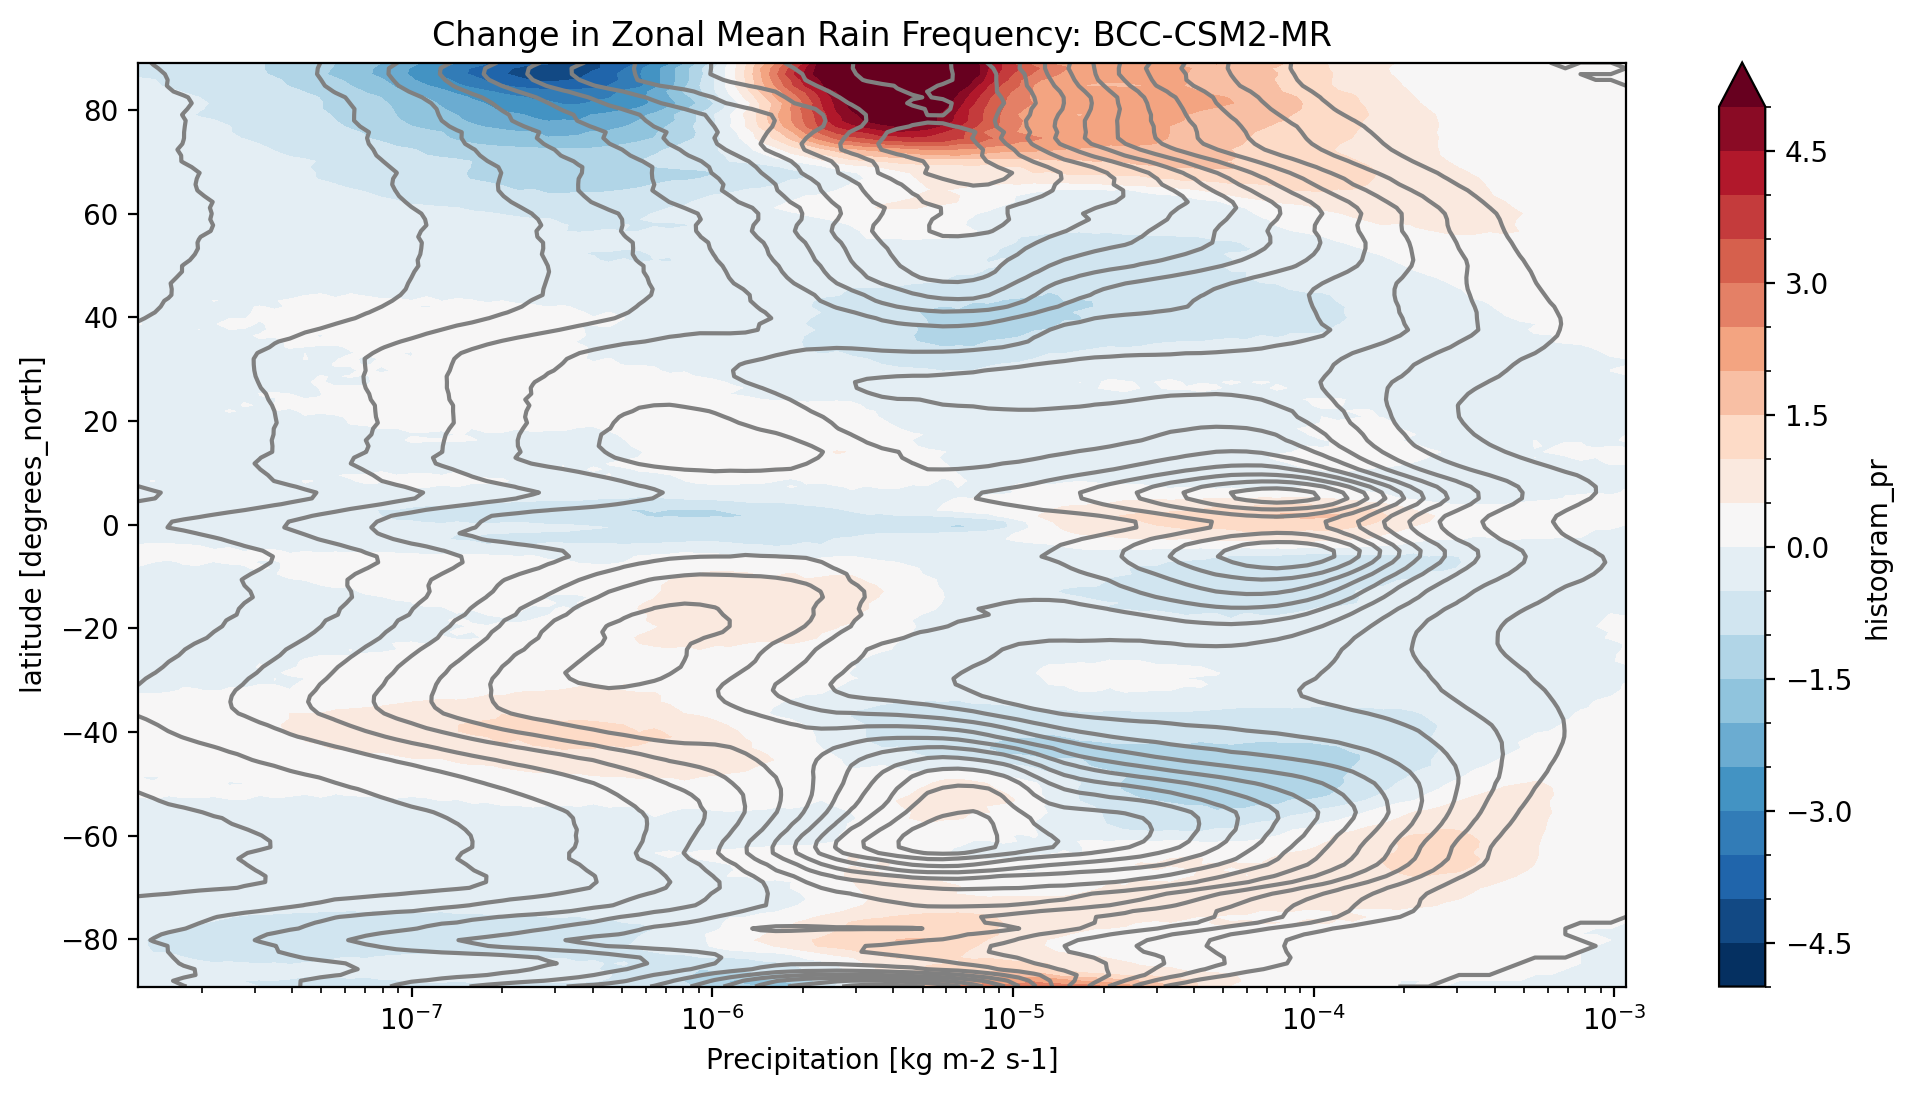

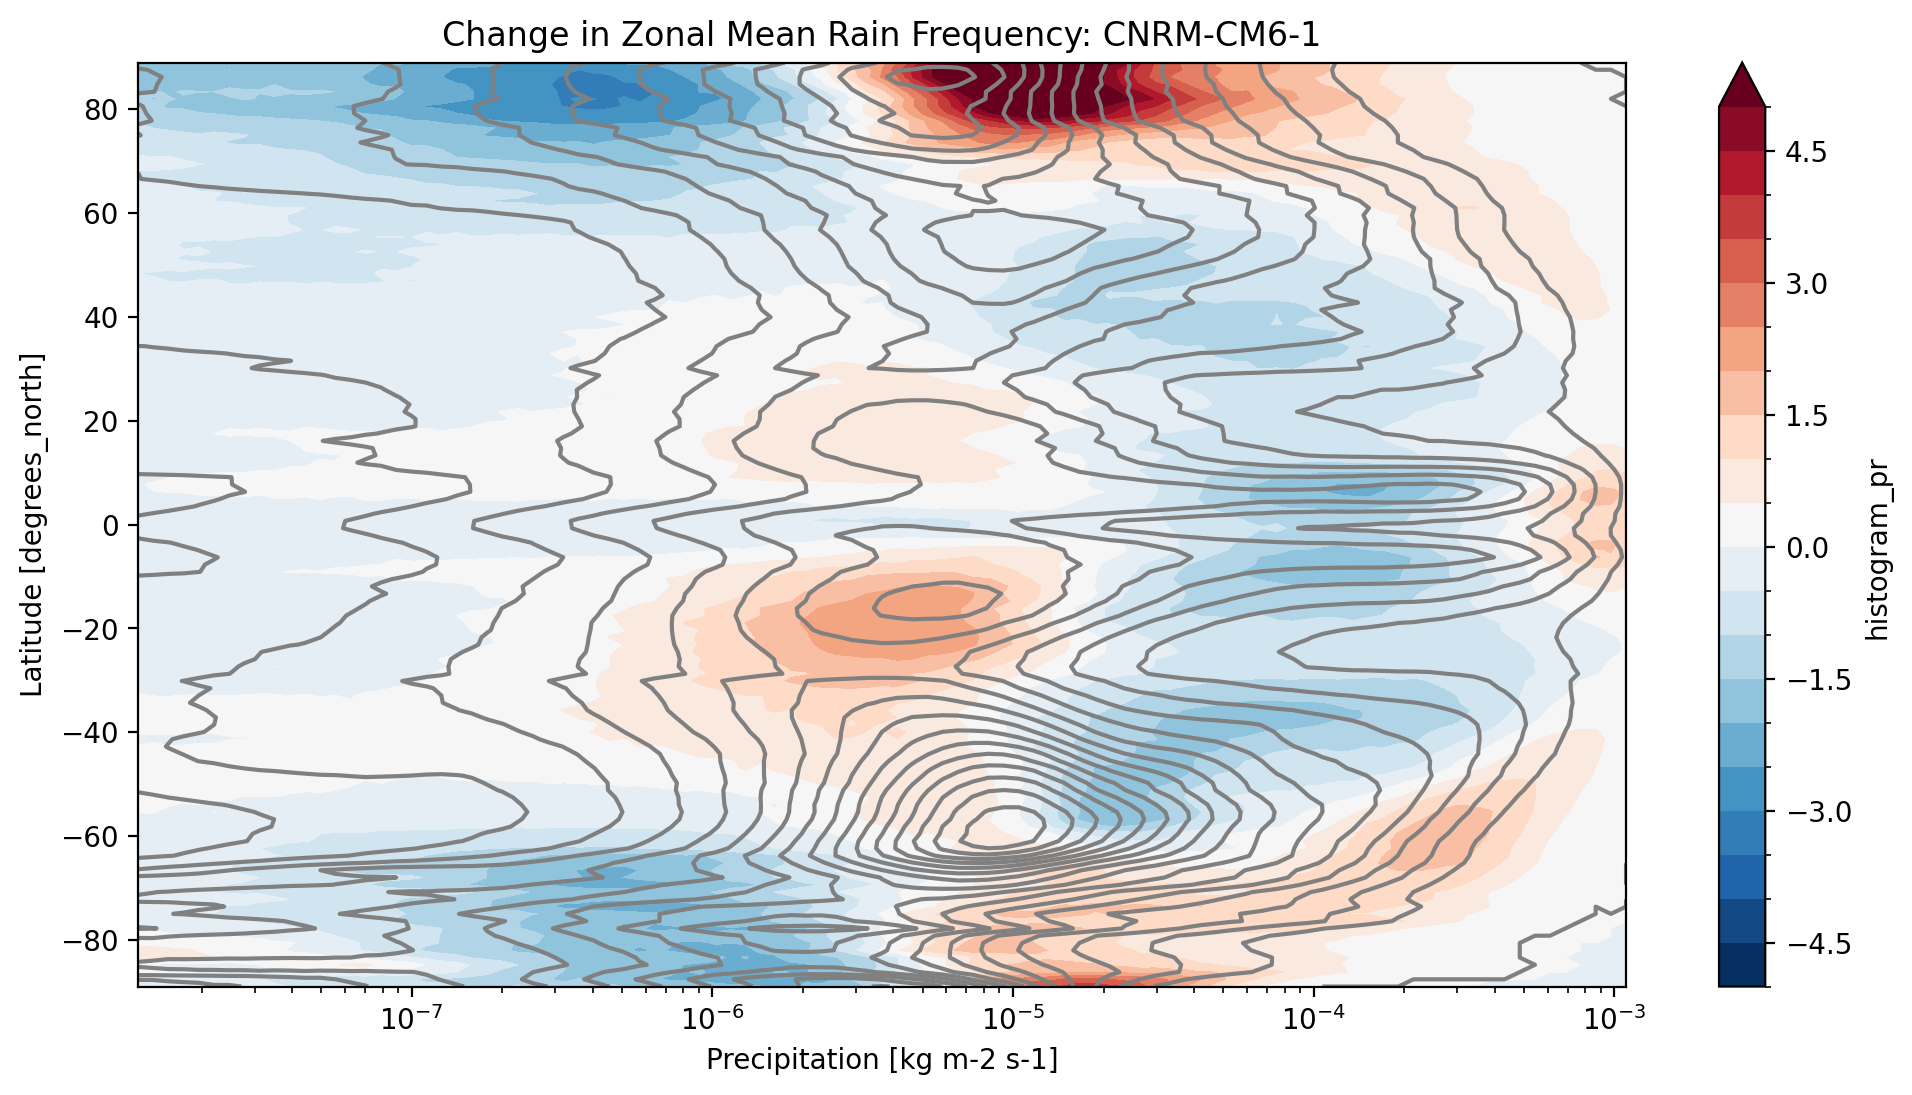

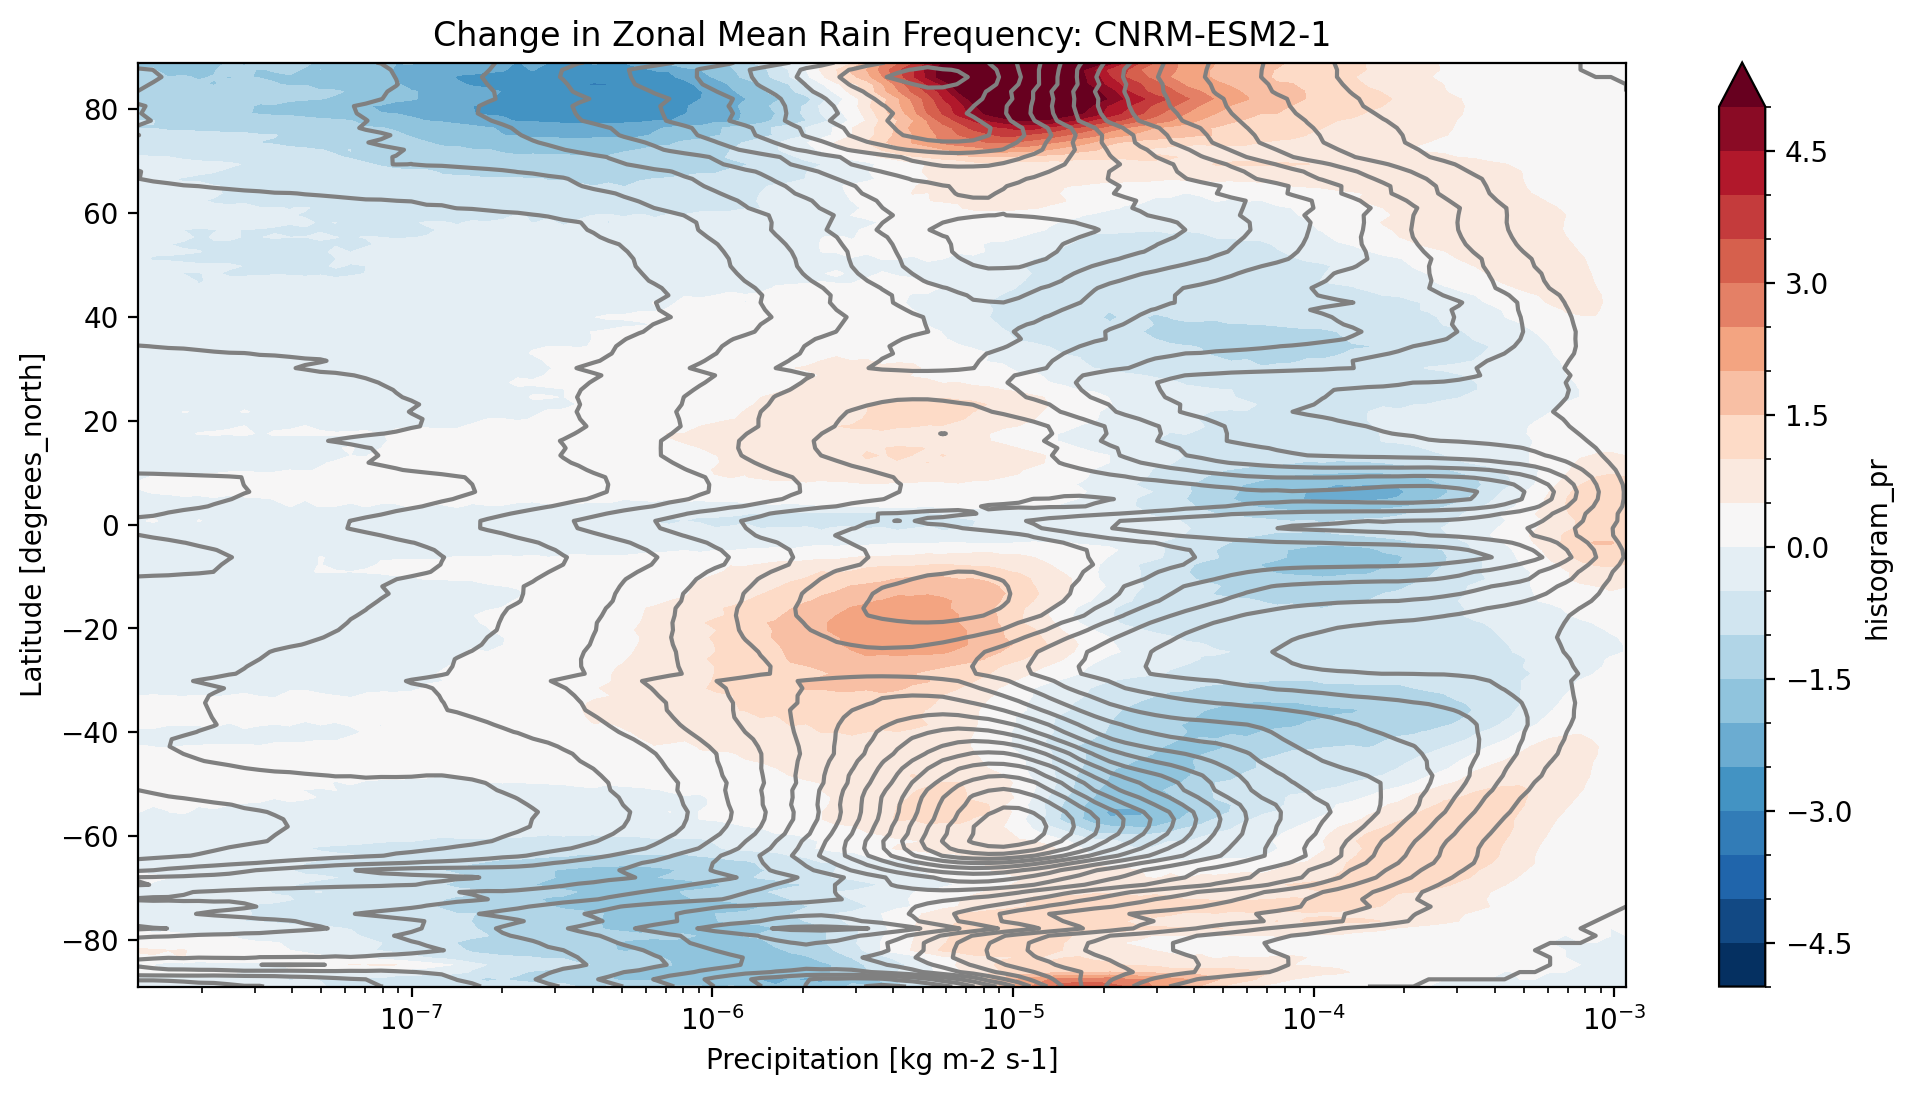

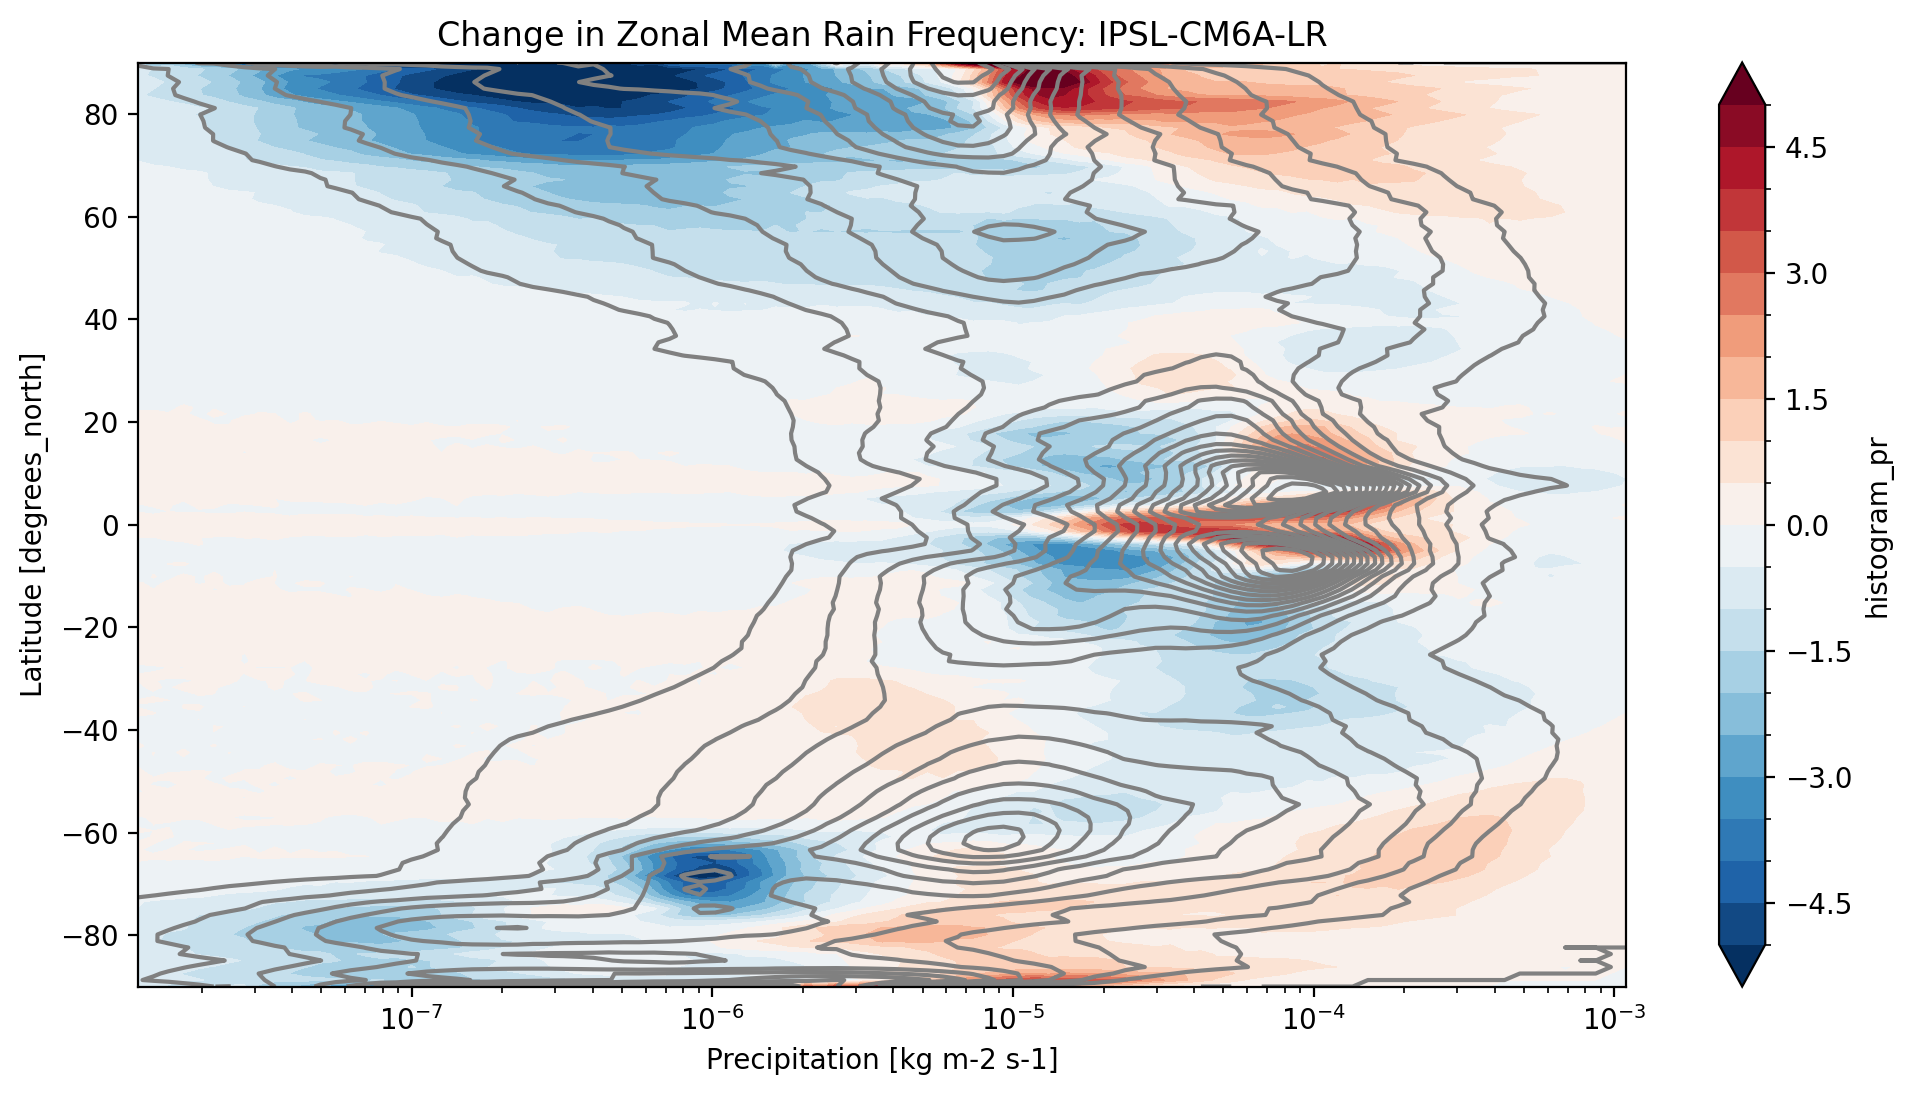

In [11]:
title = 'Change in Zonal Mean Rain Frequency'
for source_id, pr_hist in results.items():
    plt.figure()
    plot_precip_changes(pr_hist)
    plt.title(f'{title}: {source_id}')

In [12]:
client.close()
cluster.close()